In [1]:
from qutip import *
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from copy import copy


c:\Users\1163080609\anaconda3\Lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
git -version


Exception: Operator and state do not have same tensor structure: [8] and [13]

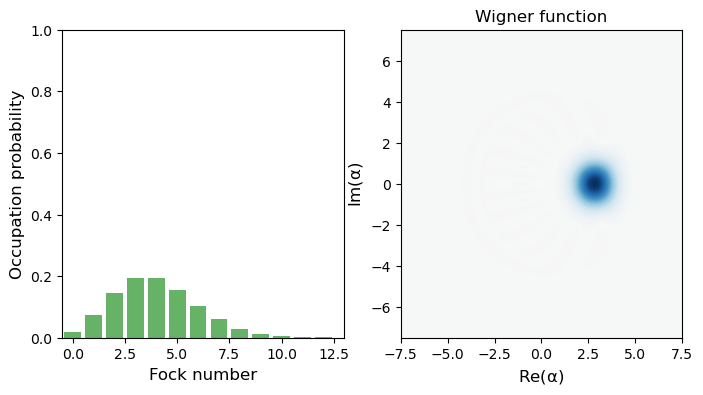

In [21]:
n=2
s=coherent_dm(2*n**2+5,n)
plot_wigner_fock_distribution(s)
expect(num(2*n**2),s)

In [ ]:
d={}
d['a']=d.get('a',[3])
d['a'].extend([1])
d
b=[d]


In [ ]:
d['an']=d.get('a',[1,2])
b

In [ ]:

class sideband:
    def __init__(self,**params) -> None:
        '''
        level,t_edge,|||
        w,yita,g,|||
        L,wd,phid,amp,sp,|||
        rho0,rho_tar|||

        (w+k)n-k/12(x**4)=wn-k/2*ad*ad*a*a
        '''

        self.params={
        # qcircuit
        'level':3,          'hascoupler':False,
        # qubtrit params,   GHz/2pi
        'w':[7,5,0],        'yita':[100,300,0],         'g':[100,0,0],
        # drive params,      GHz/2pi,rad,1
        # tp is time_pointer
        'wd':[5.15,6],      'phid':[0,0],               'sp_eff':[1,0],
        'sp_direct':None,   'arrow_ideal':[1,1,1],      'tp':0,

        # envelope,         ns,ns,GHz/2pi
        'L':100,            't_edge':10,               'amp':0.1,
        # simulate
        'Tstep':None,       'rho0':0,                  'rho_tar':None,
        'ksp':None,         'pre_scan':False,          'mix':False 
        }

        self.params.update(params)
        self.params0=copy(self.params)
        self.__setparams(self.params)
   
    def __setparams(self,dic):
        for p in dic:
            setattr(self,p,dic[p])
        
        # qcircuit
        global n
        n=self.level

        # ideal arrow/target state
        self.arrow_squ,self.arrow_norm,\
        self.p_ideal,self.t_coeff=self.ideal


        # qubtrit params,   GHz,MHz,MHz
        self.H0=self.__H0
        self.ee,self.es,self.proj=self.__eigen
        self.e1,self.e2=self.ee[2],self.ee[1]
        self.e11,self.e22=self.ee[self.to(1)],self.ee[self.to(2)]
        
        # params pre_guess
        if  self.pre_scan:
            self.ws_g,self.wp_g=self.wd[0],self.wd[1]
        else:
            self.ws_g=self.e11/2
            self.wp_g=(self.e22-self.e11)/2
        self.wd_g=[self.ws_g,self.wp_g]
        self.ks_g=1/(self.e1-self.ws_g)+1/(self.e1+self.ws_g)
        self.kp_g=1/(self.e1-self.wp_g)+1/(self.e1+self.wp_g)

        # drive
        self.ws,self.wp=self.wd[0],self.wd[1]
        self.envelope=self.__envelope
        self.up_edge,self.down_edge,self.plant=self.__envelope_slice
        self.ks,self.kp,self.sp=self.__sp
        self.DS,self.UDS,self.DDS,self.PDS=self.__DS
        self.HD=self.__HD

        # d
        self.ds_g=2*(self.sp[0]*self.amp*self.ks_g)**2*\
            self.yita[0]*self.g[0]/(self.e1-self.e2)
        # 差了4倍
        self.ds_g=self.ds_g/4

        self.dp_g=4*(self.sp[1]*self.amp*self.kp_g)**2*\
            self.yita[0]*self.g[0]/(self.e1-self.e2)
        # 差了2倍
        self.dp_g=self.dp_g/2
        self.d_eff_g=[self.ds_g,self.dp_g]
        
        self.T_g=8/(2*(self.amp*self.ks_g)**2*\
            self.yita[0]*self.g[0]/(self.e1-self.e2))
 

        # simulate
        if self.Tstep==None:    
            self.Tstep=int(self.L*10*5+1)
        self.H=[2*np.pi*self.H0,[2*np.pi*self.HD,self.DS]]
        self.H_up       =[2*np.pi*self.H0,[2*np.pi*self.HD,self.UDS]]
        self.H_down     =[2*np.pi*self.H0,[2*np.pi*self.HD,self.DDS]]
        self.H_plant    =[2*np.pi*self.H0,[2*np.pi*self.HD,self.PDS]]
        self.tlist=np.linspace(0,self.L,self.Tstep)
        if self.rho_tar==None:
            self.rho_tar=self.rho0+1
    
    def update(self,dic=(),**params):
        self.params.update(dic)
        self.params.update(params)
        self.__setparams(self.params)

    @property
    def ideal(self):
                # ideal arrow/target state
        am=np.linalg.norm(self.arrow_ideal)
        a_squ=[(i/am)**2 for i in self.arrow_ideal]
        a_nor=[i/am for i in self.arrow_ideal]
        x,y=a_nor[0],a_nor[1]
        fp=-(y**2+2*x-2)/(x**2-2*x+1)
        p_ide=np.sqrt(fp-1)
        t_coeff=np.arccos(1+x*fp-fp)/2/np.pi
        return a_squ,a_nor,p_ide,t_coeff


    @property
    def __envelope(self):
        return lambda t,args:\
            self.amp*(0.5*np.cos(np.pi*t/self.t_edge-np.pi)+0.5)\
        if 0<=t<=self.t_edge else\
            self.amp*(0.5*np.cos(np.pi*(t-self.L)/self.t_edge-np.pi)+0.5)\
        if (self.L-self.t_edge)<=t<=self.L else\
            self.amp\
        if self.t_edge<t<(self.L-self.t_edge) else 0
    @property
    def __envelope_slice(self):
        return lambda t,args:\
            self.amp*(0.5*np.cos(np.pi*(t-self.tp)/self.t_edge-np.pi  )+0.5),\
            lambda t,args:\
            self.amp*(0.5*np.cos(np.pi*(t-self.tp)/self.t_edge        )+0.5),\
            lambda t,args: self.amp

    
    @property 
    def __sp(self):
        sp_eff,         ks_g,       kp_g,       ws,         wp=\
        self.sp_eff,    self.ks_g,  self.kp_g,  self.ws,    self.wp
        ks,kp,sp=0,0,0
        sp=[0,0]
        # theoral:sp=[sp_eff[0],np.sqrt(sp_eff[1]*0.5)*(ks_g/kp_g)]

        ks=1/(self.e1-ws)+1/(self.e1+ws)
        kp=1/(self.e1-wp)+1/(self.e1+wp)
        if self.ksp==None:    
            ksp=0.5*(ks_g/kp_g)
        else:
            ksp=self.ksp
        self.ksp_g=ksp
        if self.sp_direct==None:
            sp[0]=sp_eff[0]
            sp[1]=np.sqrt(sp_eff[1])*ksp
        else:
            sp=self.sp_direct
        return ks,kp,sp
    @property
    def __DS(self):
        DS=lambda t,args:0
        UDS,DDS,PDS=lambda t,args:0,lambda t,args:0,lambda t,args:0
        def cos(sp,a,w,phi): 
            return lambda t,args:sp*a(t,args)*np.cos(2*np.pi*w*t+phi)
        def add(f1,f2):
            return lambda t,args:f1(t,args)+f2(t,args)

        for i in range(len(self.wd)):
            DS =add(cos(self.sp[i],self.envelope,
                       self.wd[i],self.phid[i]),DS)
        for i in range(len(self.wd)):
            UDS=add(cos(self.sp[i],self.up_edge,
                       self.wd[i],self.phid[i]),UDS)
        for i in range(len(self.wd)):
            DDS=add(cos(self.sp[i],self.down_edge,
                       self.wd[i],self.phid[i]),DDS)
        for i in range(len(self.wd)):
            PDS=add(cos(self.sp[i],self.plant,
                       self.wd[i],self.phid[i]),PDS)
        
        return DS,UDS,DDS,PDS
    @property
    def __HD(self):
        a=destroy(n)
        ad=create(n)
        I=qeye(n)
        D=tensor(a+ad,I)
        return D       
    @property
    def __H0(self):
        w,g,yita=self.w,self.g,self.yita
        a,ad,I=destroy(15),create(15),qeye(n)
        x=a+ad
        def trunc(x):
            return Qobj(x[:n,:n])

        h0=(w[0]+yita[0])*ad*a-yita[0]/12*(x**4)
        h1=(w[1]+yita[1])*ad*a-yita[1]/12*(x**4)

        h0,h1=trunc(h0),trunc(h1)
        G01=g[0]*tensor(trunc(x),trunc(x))

        H0=tensor(h0,I)+tensor(I,h1)+G01
        return H0 
            # return trunc(h0)
    @property
    def __eigen(self):
        to,L=self.to,self.L
        eigen=self.H0.eigenstates()
        ee=[e-eigen[0][0] for e in eigen[0]]
        es=eigen[1]
        proj=[s*s.dag() for s in es]
        xita1=2*np.pi*ee[to(1)]*L
        xita2=2*np.pi*ee[to(2)]*L
        self.state_mix=(es[0]+
                        np.exp(-1j*xita1)*es[to(1)]+
                        np.exp(-1j*xita2)*es[to(2)]).unit()
        self.rho_mix=self.state_mix*self.state_mix.dag()
        # self.ground_state=es[0]
        # self.max_mixed_state
        return ee,es,proj  
    def drive_sign_plot(self,target='DS'):
        if target=='DS':
            func=self.DS
        elif target=='envelope':
            func=self.envelope
        fix,ax=plt.subplots()
        ax.plot(self.tlist,list(map(func,self.tlist,self.tlist)))
    def to(self,x):
        #n=3,4,5 p22=p[8,11,12] ,
        #assume 11,22 setten at middle of exciting number subspace
        #without consider 30 exceed 04
        #assume w2=2w-yita,w3=3w-2yita
        if x==0:
            return 0
        elif x==1:
            return 4
        elif x==2:
            if n==3:
                return 8
            elif n==4:
                return 11
            elif n==5:
                return 12
            elif n>=6:
                return 13
    def g_Level(self,target=None,gstop=None):
        if gstop==None:
            gstop=self.g[0]
        z=[]
        glist=np.linspace(0,gstop,100)
        for p in glist:
            self.update(g=[p])
            ee=self.ee
            z.append(ee)
        z=np.transpose(z)
        fix,ax=plt.subplots()
        if target==None:
            ax.plot(glist,np.transpose(z))
        else:
            ax.plot(glist,z[self.to(target)])
    

    def result_norm(self,result):
        res=result
        res.expect=[[i/j for i,j in zip(res.expect[k],res.expect[3])] 
                    for k in range(len(result.expect))]
        return res
    def scan_wd(self,wstart,wstop,wstep,sp=0,runplot=False,plot=True):
        '''
        sp=0,wd=[w_scan,wp]
        sp=1,wd=[ws,w_scan]
        '''
        rho0,rho_tar=self.rho0,self.rho_tar
        wdlist=np.linspace(wstart,wstop,wstep)
        wd=self.wd
        z=[]
        for w in wdlist:
            wd[sp]=w
            # wdt=[lambda t,args:wd]
            self.update(wd=wd)
            result=self.run(plot=runplot)
            z.append(np.transpose(result.expect))
        z=np.transpose(z)
        print(shape(z))

        if plot:
            self.imshow([z[rho_tar],wstart,wstop,wstep],rho_tar)

        return [z,wstart,wstop,wstep,wdlist]
    def find_w_mat(self,input,target=None,plot=False):
        z,          wstart,     wstop,      wstep,      wdlist=\
        input[0],   input[1],   input[2],   input[3],   input[4]
        dom=wstop-wstart
        dpi=(wstop-wstart)/wstep
        error=list(np.min(z[-1],axis=0))
        w_arg=np.argmin(error,axis=0)
        wm_guess=wdlist[w_arg]
        isside= w_arg==0 or w_arg==wstep-1
        return [wm_guess,dom,dpi,isside]
    
    def GateProcess(self,result,population=True,bloch=True,show_list=[0,1,2,3,-1]):
        if population:
            fig, ax = plt.subplots()
            ax.plot(result.times ,
            # np.transpose([result.expect[p]]))
            # np.transpose([expect for expect in result.expect]))
            np.transpose([result.expect[i] for i in show_list]))
            ax.set_xlabel('t/ns')
            ax.set_ylabel('Population')
            ax.legend(['P00','P11','P22','tot','error'])
            plt.show()
        if bloch:
            b=Bloch()
            b.add_points([result.expect[0],result.expect[1],
                          result.expect[2]],'l')
            b.show()


    def run_lego(self,  res_pre=None,   enve_type='p',      L=None,
                        plot=False,     population=True,    bloch=False,):
        '''return result'''
        
        proj,to=self.proj,self.to
        rho0,rho_tar,mix=self.rho0,self.rho_tar,self.mix

        if plot:print(f'run start,T={L}')
        
        if res_pre==None:
            self.update(tp=0)
            rho0=proj[to(rho0)]
        else:
            self.update(tp=res_pre.times[-1])
            rho0=res_pre.final_state
            
        
        tlist=np.linspace(self.tp,self.tp+L,int(L*50)+1)
        arrow=self.arrow_squ
        op=Options(store_final_state=True)
        H=      self.H_down  if enve_type=='d' \
        else    self.H_up    if enve_type=='u' \
        else    self.H_plant if enve_type=='p' \
        else    self.H
        



        
        # rho_mix=self.state_mix*self.state_mix.dag()
        # e_ops=[proj[to(0)],proj[to(1)],proj[to(2)],rho_mix,rho_mix]
        e_ops=[proj[to(0)],proj[to(1)],proj[to(2)]]
        result=mesolve(H,rho0,tlist,None,e_ops,options=op)
        tot,error=[],[]
        
        tot=[i+j+k for i,j,k in 
             zip(result.expect[0],result.expect[1],result.expect[2])]
        leakage=[1-i for i in tot]
        coeff=np.abs(1-arrow[0])+np.abs(0-arrow[1])+np.abs(0-arrow[2])

        if mix:
            # ==max_delta_ijk
            # error=[np.abs(i-j)+np.abs(j-k)+np.abs(l) for i,j,k,l in 
            #        zip(result.expect[0],result.expect[1],result.expect[2],
            #            leakage)]

            error=[(np.abs(i-arrow[0])+np.abs(j-arrow[1])+np.abs(k-arrow[2])
                    +np.abs(l))/coeff for i,j,k,l in 
                    zip(result.expect[0],result.expect[1],result.expect[2],
                       leakage)]
        else:
            error=[t-p for t,p in zip(tot,result.expect[rho_tar])]
        
        # result.expect[3]=tot
        result.expect.append(tot)
        result.expect.append(leakage)
        result.expect.append(error)
        result.min=min(error)
        #expect[3]=tot,expect[-1]=error
        if res_pre!=None:
            tpm=copy(list(res_pre.times))
            tpm.extend(result. times)
            result.times=tpm
            for i in range(len(result.expect)):
                rpm=copy(list(res_pre.expect[i]))
                rpm.extend(result.expect[i])
                result.expect[i]=rpm

        
        if plot:
            self.GateProcess(result=result,
                             population=population,bloch=bloch)
            print('run end')

        return result



    def run(self,plot=False,population=True,bloch=False,
            norm=False,norm_plot=False):
        '''return result or [result,rrsult_norm]'''
        if plot:print(f'run start,T={self.L}')
        proj,to,tlist,H=self.proj,self.to,self.tlist,self.H
        rho0,rho_tar,mix=self.rho0,self.rho_tar,self.mix
        arrow=self.arrow_squ
        op=Options(store_final_state=True)

        rho0=proj[to(rho0)]
        # rho_mix=self.state_mix*self.state_mix.dag()
        # e_ops=[proj[to(0)],proj[to(1)],proj[to(2)],rho_mix,rho_mix]
        e_ops=[proj[to(0)],proj[to(1)],proj[to(2)]]
        result=mesolve(H,rho0,tlist,None,e_ops,options=op)
    
        # print(shape(result.times))
        tot,error=[],[]
        
        tot=[i+j+k for i,j,k in 
             zip(result.expect[0],result.expect[1],result.expect[2])]
        leakage=[1-i for i in tot]
        coeff=np.abs(1-arrow[0])+np.abs(0-arrow[1])+np.abs(0-arrow[2])

        if mix:
            # ==max_delta_ijk
            # error=[np.abs(i-j)+np.abs(j-k)+np.abs(l) for i,j,k,l in 
            #        zip(result.expect[0],result.expect[1],result.expect[2],
            #            leakage)]

            error=[(np.abs(i-arrow[0])+np.abs(j-arrow[1])+np.abs(k-arrow[2])
                    +np.abs(l))/coeff for i,j,k,l in 
                    zip(result.expect[0],result.expect[1],result.expect[2],
                       leakage)]
        else:
            error=[t-p for t,p in zip(tot,result.expect[rho_tar])]
        
        # result.expect[3]=tot
        result.expect.append(tot)
        result.expect.append(leakage)
        result.expect.append(error)
        result.min=min(error)
        #expect[3]=tot,expect[-1]=error
        
        if plot:
            self.GateProcess(result=result,
                             population=population,bloch=bloch)
            print('run end')
        if norm_plot:
            res=self.result_norm(result)
            self.GateProcess(result=res,
                             population=population,bloch=bloch)
        if norm:
            return [result,self.result_norm(result)]
        return result


    def run_fin(self,tstart=None,tstop=None,tstep=None,
                    plot=False,population=True,bloch=False):
        L,t_edge=self.L,self.t_edge
        rl=self.run_lego
        if tstart==None:
            tstart,tstop=2*t_edge,self.L
        if tstep==None:
            tstep=1*(int(self.L/t_edge))+1
        tplist=np.linspace(tstart,tstop,tstep)

        class output:
            pass
        times,expect=[],[]

        res=rl(enve_type='u',  L=t_edge)
        res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)

        for tp in tplist[1:]:
            tp_pre=res.times[-1]
            L=tp-tp_pre
            res     =rl(res_pre=res,    enve_type='p',  L=L-t_edge)
            res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)
            times.append(res_fin.times[-1])
            expect.append(np.transpose(res_fin.expect)[-1])
            
        expect=np.transpose(expect)

        output.times=times
        output.expect=expect

        if plot:
            self.GateProcess(result=output,
                             population=population,bloch=bloch)
            print('run end')
        return output


        
        

    def run_fin_old(self,tstart,tstop,tstep,
                plot=False,population=True,bloch=True,show=[0,1,2,-1]):
        t_fin_list=np.linspace(tstart,tstop,tstep)
        class output:
            pass
        output.times=t_fin_list
        output.expect=[]
        for t in t_fin_list:
            self.update(L=t)
            res=copy(self.run())
            output.expect.append(np.transpose(res.expect)[-1])
        output.expect=np.transpose(output.expect)
        if plot:
            self.GateProcess(result=output,
                             population=population,bloch=bloch)
            print('run end')
        return output
    

    def wd_fit(self,result,sp=0,plot=True,correct=1):
        '''
        single wave Rabi fit
        return [d_eff,F,t0,c,T]'''
        print(f'wd_fit start \n sp={sp}' )
        if correct!=1:
            print('correct!=1')
        edge_step=int(self.Tstep*self.t_edge/self.L)+2
        d_guess=self.d_eff_g[sp]
        P_tar=result.expect[sp+1]
        tlist=result.times
        def func(t,d_eff,F,t0):
            return F*(0.5*(1-np.cos(2*np.pi*d_eff*(t-t0))))
        guess=[d_guess*correct,0.8,self.t_edge/2]
        # print(f',sp={sp}' )
        bounds=([d_guess*0.5,   0,      0,         ],\
                [d_guess*(correct+1),     1.1,      self.t_edge])
        coeff, var_matrix = curve_fit(func,tlist,P_tar,guess,
                                      bounds=bounds,maxfev=10000)
        if plot==True:
            plt.plot(tlist, P_tar)
            plt.plot(tlist, func(tlist,*coeff),color='red')
            plt.xlabel('t')
            plt.ylabel('error')
            plt.title('Linear Fit')
            plt.show()
        T=1/coeff[0]
        coeff=list(coeff)
        coeff.append(T)
        print(f'guess value of [d_eff,F,t0]={guess}')
        print(f"fit coeff [d_eff,F,t0,T]={coeff}\n wd_fit end")
        return coeff

    def mix_wave_fit(self,result,plot=True):
        '''return [guess,coeff,T,p]\n
        guess=[d_eff,F,t0,p**2]\n
        coeff[i]=[d_eff,F,t0,p]
                '''
        print(f'mix_wave_fit start \n ' )
        edge_step=int(self.Tstep*self.t_edge/self.L)+2


        d_guess=self.d_eff_g[0]
        # error=result.expect[-1][edge_step:self.Tstep-edge_step]

        y=[result.expect[i] for i in [0,1,2]]
        tlist=result.times

        def func0(t,d_eff,F,t0,p2):
            return 1*((np.cos(2*np.pi*d_eff*(t-t0))+p2)**2)/((1+p2)**2)
        def func1(t,d_eff,F,t0,p2):
            return F*0.5*(1-np.cos(4*np.pi*d_eff*(t-t0)))
        def func2(t,d_eff,F,t0,p2):
            return F*((1-np.cos(2*np.pi*d_eff*(t-t0)))**2)
                # ((np.sqrt(p2)/(1+p2))**2)
        func=[func0,func1,func2]

        guess=[d_guess,0.5,self.t_edge/2,self.p_ideal**2]
        gue=copy(guess)
        # print(f',sp={sp}' )
        bounds=([d_guess*0.1,   0,    0,              0],\
                [d_guess*5,     1,    self.t_edge,    2])
        coeff=[0,0,0]
        print(f'guess={guess}')
        for i in [0,1,2]:
            coeff[i], var_matrix = curve_fit(func[i],tlist,
                                             y[i],gue,bounds=bounds)
            gue=copy(coeff[i])
            gue[1]=0.5
        print(type(coeff[0]))
        if plot==True:
            for i in [0,1,2]:
                plt.plot(tlist, np.transpose(y[i]))
                plt.plot(tlist, func[i](tlist,*coeff[i]),color='red')
                plt.xlabel('t/ns')
                plt.ylabel('P')
                plt.title('Linear Fit')
                plt.show()
                coeff[i]=list(coeff[i])
        
        coeff[0][3]=np.sqrt(coeff[0][3])
        coeff[1][3]=np.sqrt((1/coeff[1][1])-1)
        F2=coeff[2][1]
        coeff[2][3]=[(1+np.sqrt(1-4*F2))/(2*np.sqrt(F2)),
                     (1-np.sqrt(1-4*F2))/(2*np.sqrt(F2))]
        
        print('d_eff,F,t0,p2:\t\tguess\t\tcoeff')
        print(guess)
        for i in [0,1,2]:
            print(coeff[i])
        T=(1/coeff[0][0]+1/coeff[1][0]+1/coeff[2][0])/3
        p=coeff[0][3]
        # coeff=list(coeff)
        # coeff.append(T)
        # print(f'guess value of [d_eff,F,t0,p2]={guess}')
        print(f"\n mix_wave_fit end")
        # print(coeff)
        return [guess,coeff,T,p]


    ###############################################

    ###############################################

    def auto_scan_scope_error(self,sp=0,dpim=None,plot=True,dom=0.5):
        '''return [w,input]'''
        print(f'auto_scan_scope start \n sp={sp}' )
        if dpim==None:
            dpim=0.1*self.d_eff_g[sp]
        wsp,wd=self.wd_g,self.wd
        dw=self.e1-self.e2
        dpi0=0.02*dw
        dpi=dpi0
        w=[wsp[sp]-2*dpi,wsp[sp]-1*dpi,wsp[sp],wsp[sp]+1*dpi,wsp[sp]+2*dpi]
        error=[0,0,0,0,0]

        wm=w
        z,wdlist,iter_list=[],[],[]
        global iter_num
        iter_num=1
        print('iter_num=\n')
        def iter(i):
            global iter_num
            print(iter_num,end='\t')
            if iter_num%5==0:
                print('\n')
            iter_num=iter_num+1
            wd[sp]=w[i]
            self.update(wd=wd)
            result=self.run(plot=True)
            error[i]=np.min(result.expect[-1])
            wdlist.append(w[i])
            z.append(np.transpose(result.expect))

            iter_list.append(iter_num)
            

        # T=2*self.t_edge+0.5*self.T_g/4
        T=2*self.t_edge+0.25*1/self.d_eff_g[sp]
        self.update(L=T)
        print(f'T for scan:{T}')
        for i in [0,2,4]:
            iter(i)
            
        while dpi>dpim:
            # print(f'w--error:{[w,error]}')
            # print(f'dpi={dpi}')
            if error[0]<error[4]:
                iter(1)
                if error[1]<error[2] and error[1]<error[0]:
                    w=list(np.linspace(w[0],w[2],5))
                    error[0]=error[0]
                    error[4]=error[2]
                    error[2]=error[1]
                else:
                    iter(3)
                    j=np.argmin(error)
                    print(f'j={j}')
                    w=list(np.linspace(w[j-1],w[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            elif error[0]>=error[4]:
                iter(3)
                if error[3]<error[2] and error[3]<error[4]:
                    w=list(np.linspace(w[2],w[4],5))
                    error[0]=error[2]
                    error[4]=error[4]
                    error[2]=error[3]
                else:
                    iter(1)
                    j=np.argmin(error)
                    print(f'j={j}')
                    w=list(np.linspace(w[j-1],w[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            dpi=dpi/2


        # print([w[2],error[2]])
        z=np.transpose(z)
        wdlist_sort,zm=zip(*sorted(zip(
            wdlist,np.transpose(z[self.rho_tar]))))
        
        input=[np.transpose(zm),wsp[sp]-dpi0,wsp[sp]+dpi0,100]
        if plot:
            self.imshow(input=input)
            fix,ax=plt.subplots()
            ax.plot(iter_list,wdlist)
            ax.set_xlabel('iter/n')
            ax.set_ylabel('wd/GHz')
            plt.show()
        
        print(f'dpi={dpim},w_match={w[2]} \n auto_scan_scope end')
        return [w[2],input]

    def auto_scan_scope(self,sp=0,tar=None,T_coeff=0.1,dom=0.5,
                        dpim=1,plot=True,runplot=False):
        '''tar=0,1,2
        return [w,input]'''
        if plot:print(f'auto_scan_scope start \n sp={sp}' )
        dpim=dpim*0.01*self.d_eff_g[sp]
        if tar==None:
            tar=self.rho_tar
        wd,to=self.wd,self.to
        if self.pre_scan:
            wsp=self.wd
        else:
            wsp=self.wd_g
        # dw=self.e1-self.e2
        dwsp=np.abs(self.ws_g-self.wp_g)
        dpi0=dom*0.25*dwsp
        dpi=dpi0
        # w=[wsp[sp]-3*dpi,wsp[sp]-2*dpi,wsp[sp]-dpi,wsp[sp],wsp[sp]+dpi]
        w=list(np.linspace(wsp[sp]-2*dpi,wsp[sp]+2*dpi,5))
        P_tar=[0,0,0,0,0]

        wm=copy(w)
        z,wdlist,iter_list=[],[],[]
        global iter_num
        iter_num,dpi_num=1,1

        def iter(i):
            global iter_num
            if plot:print((dpi_num,iter_num),end=',')
            iter_num=iter_num+1
            wd[sp]=w[i]
            self.update(wd=wd)
            result=self.run(plot=runplot,bloch=False)

            P_tar[i]=np.max(result.expect[tar])
            wdlist.append(w[i])
            z.append(np.transpose(result.expect))

            iter_list.append(iter_num)
            
        # T=2*self.t_edge+0.5*self.T_g/4
        T=2*self.t_edge+T_coeff*1/self.d_eff_g[sp]

        # T=2*self.t_edge+1*1/self.d_eff_g[0]
        self.update(L=T)
        print(f'T for scan:{T}')
        print('iter_num=')
        for i in [0,2,4]:
            iter(i)
        while dpi>dpim:
            # print(f'w--error:{[w,error]}')
            # print(f'dpi={dpi}')
            if P_tar[0]>P_tar[4]:
                iter(1)
                if P_tar[1]>P_tar[2] and P_tar[1]>P_tar[0]:
                    w=list(np.linspace(w[0],w[2],5))
                    P_tar[0]=P_tar[0]
                    P_tar[4]=P_tar[2]
                    P_tar[2]=P_tar[1]
                else:
                    iter(3)
                    j=np.argmax(P_tar)
                    # print(f'j={j}')
                    if j!=0 and j!=4:
                        w=list(np.linspace(w[j-1],w[j+1],5))
                        P_tar[0]=P_tar[j-1]
                        P_tar[4]=P_tar[j+1]
                        P_tar[2]=P_tar[j]
                    elif j==0:
                        w=list(np.linspace(
                            wsp[sp]-(4+dpi_num)*dpi,
                            wsp[sp]-dpi_num*dpi,5))
                        P_tar[4]=P_tar[1]
                        P_tar[3]=P_tar[0]
                        for i in [0,2]:
                            iter(i)
                    else:
                        w=list(np.linspace(
                            wsp[sp]+dpi_num*dpi,
                            wsp[sp]+(4+dpi_num)*dpi,5))
                        P_tar[0]=P_tar[3]
                        P_tar[1]=P_tar[4]
                        for i in [2,4]:
                            iter(i)
                         
            elif P_tar[0]<=P_tar[4]:
                iter(3)
                if P_tar[3]>P_tar[2] and P_tar[3]>P_tar[4]:
                    w=list(np.linspace(w[2],w[4],5))
                    P_tar[0]=P_tar[2]
                    P_tar[4]=P_tar[4]
                    P_tar[2]=P_tar[3]
                else:
                    iter(1)
                    j=np.argmax(P_tar)
                    # print(f'j={j}')
                    if j!=0 and j!=4:
                        w=list(np.linspace(w[j-1],w[j+1],5))
                        P_tar[0]=P_tar[j-1]
                        P_tar[4]=P_tar[j+1]
                        P_tar[2]=P_tar[j]
                    elif j==0:
                        w=list(np.linspace(
                            wsp[sp]-(4+dpi_num)*dpi,
                            wsp[sp]-dpi_num*dpi,5))
                        P_tar[4]=P_tar[1]
                        P_tar[3]=P_tar[0]
                        for i in [0,2]:
                            iter(i)
                    else:
                        w=list(np.linspace(
                            wsp[sp]+dpi_num*dpi,
                            wsp[sp]+(4+dpi_num)*dpi,5))
                        P_tar[0]=P_tar[3]
                        P_tar[1]=P_tar[4]
                        for i in [2,4]:
                            iter(i)

            dpi=dpi/2
            dpi_num+=1
            if plot:
                if dpi_num%4==1:
                    print('\n')

        print('\n')
        # print([w[2],P_tar[2]])
        z=np.transpose(z)
        print(type(np.transpose(z[self.rho_tar])))
        print(wdlist)
        print(shape(zip(wdlist,np.transpose(z[self.rho_tar]))))
        print(zip(wdlist,np.transpose(z[self.rho_tar])))

        wdlist_sort,zm=zip(
            *sorted(zip(wdlist,list(np.transpose(z[self.rho_tar])))))
        
        input=[np.transpose(zm),wsp[sp]-dpi0,wsp[sp]+dpi0,100]
        if plot:
            self.imshow(input=input)
            fix,ax=plt.subplots()
            ax.plot(iter_list,wdlist)
            ax.set_xlabel('iter/n')
            ax.set_ylabel('wd/GHz')
            plt.show()
        
        print(
            f'dpi={dpim*1000}MHz,w_match={w[2]}GHz \n auto_scan_scope end')
        return [w[2],input]

    def auto_scan_amp(self,astart,astop,astep,
                      plot=True,mix=False,runplot=False):
        '''MIX: While wp far away from wp_mat, 
        wp only affect ws by delta_ws_p,
        therotically assumed as delta_wp_p which is affect of wp on itself.
        '''
        print(f'auto_scan_amp start \nastart,astop,astep=\
              {astart,astop,astep}')
        if mix:
            print(f'mix={mix},sp_direct=[1,1]')
        wd=self.wd_g
        alist=np.linspace(astart,astop,astep)
        wdlist,d_eff_list,T_list=[[],[]],[[],[]],[[],[]]
        print('+'*60)
        if mix:
            for sp in[0,1]:
                self.update(rho0=sp,rho_tar=sp+1)
                for amp in alist:
                    print(f'auto_scan_amp \tsp={sp} \tamp={amp}')    
                    self.update(amp=amp)
                    wd_m=wd
                    wd_m[sp]=self.auto_scan_scope(
                        sp=sp,plot=True,runplot=runplot)[0]
                    wdlist[sp].append(wd_m[sp])
                    self.update(L=1/self.d_eff_g[sp],wd=wd_m) 
                    #auto_scan_scope改变了wd，因此改变了T_g
                    res=self.run(plot=True,bloch=False)
                    coeff=self.wd_fit(res,sp=sp)
                    d_eff_list[sp].append(coeff[0])
                    T_list[sp].append(coeff[-1])
                    print('+'*60)
        else:
            for sp in [0,1]:
                self.update(sp_direct=[1-sp,sp],rho0=sp,rho_tar=sp+1)
                for amp in alist:
                    print(f'auto_scan_amp ,sp={sp} ,amp={amp}')    
                    self.update(amp=amp)
                    wd_m=wd
                    wd_m[sp]=self.auto_scan_scope(sp=sp,plot=True)[0]
                    wdlist[sp].append(wd_m[sp])

                    self.update(L=self.T_g/2,wd=wd_m)   
                    #auto_scan_scope改变了wd，因此改变了T_g
                    res=self.run(plot=True,bloch=False)
                    coeff=self.wd_fit(res,sp=sp)
                    d_eff_list[sp].append(coeff[0])
                    T_list[sp].append(coeff[-1])
                    print('+'*60)
        wdlist=np.transpose(wdlist)
        d_eff_list=np.transpose(d_eff_list)
        T_list=np.transpose(T_list)
        
        if plot:
            fig,ax=plt.subplots()
            ax.plot(alist,wdlist)
            ax.set_xlabel('amp/2pi/GHz')
            ax.set_ylabel('w_match/2pi/GHz')
            ax.legend(['s','p'])
            plt.show()            
            fig,ax=plt.subplots()
            ax.plot(alist,d_eff_list)
            ax.set_xlabel('amp/2pi/GHz')
            ax.set_ylabel('d_eff/2pi/GHz')
            ax.legend(['s','p'])
            plt.show()
            fig,ax=plt.subplots()
            ax.plot(alist,T_list)
            ax.set_xlabel('amp/2pi/GHz')
            ax.set_ylabel('T/ns')
            ax.legend(['s','p'])
            plt.show()
        print(f'auto_scan_amp end')
        print('+'*60)
        return [alist,wdlist,d_eff_list,T_list]


    def auto_scan_mix_wave_wd_sp(self,amp,sp_direct,dom=0.8,plot=True,runplot=False,
                                 
                                 correct=2,single_wave_scan=False,suggest=True):
        '''return [w_mat_mix,sp_direct_suggest1,L_g,result,fit_result,p_cost]'''
        if plot:print('auto_scan_mix_wave_wd start')
        if plot:print(f'amp={amp}\t\tsp_direct={sp_direct}')
        w_mat_single,w_mix_drag,w_mat_mix=[0,0],[0,0],[0,0]
        d_eff_mix,wm,sp_direct_suggest,coeff=[0,0],[0,0],[0,0],[0,0]
        L_g=0
        #++++++++++++++++++++++
        if single_wave_scan:
            for sp in [0,1]:
                sp_single=[0,0]
                sp_single[sp]=sp_direct[sp]
                self.update(amp=amp,sp_direct=copy(sp_single),mix=False,
                        pre_scan=False,rho0=sp,rho_tar=sp+1)
                print(self.sp)
                w_mat_single[sp]=self.auto_scan_scope(
                    sp=sp,runplot=runplot,dom=0.8)[0]
                wm=[0,0]
                wm[sp]=w_mat_single[sp]
                self.update(wd=copy(wm),L=self.T_g/2)
                result=self.run(plot=True)
        else:
            w_mat_single=self.wd_g
        #++++++++++++++++++++++++++++
        # wd_mix_mat scan
        self.update(sp_dircet=sp_direct,mix=False,wd=copy(w_mat_single))

        d_eff=self.d_eff_g
        # for i in [0,1]:
        w_mix_drag[0]=w_mat_single[0]+0*d_eff[0]
        # print(f'{w_mix_drag[0]},{w_mat_single[0]},{5*d_eff[0]}')
        w_mix_drag[1]=w_mat_single[1]-0*d_eff[1]
            #要确保sp只有一个在共振，事实上应该再加一个拉开到非共振的ws
            #与此时共振的wp的拟合
        for sp in [1,0]:
            self.update(amp=amp,sp_direct=sp_direct,wd=copy(w_mix_drag),
                        pre_scan=True,rho0=sp,rho_tar=sp+1)
            T_coeff=[0.05,0.02]
            w_mat_mix[sp]=self.auto_scan_scope(plot=False,
                sp=sp,runplot=runplot,dom=dom,T_coeff=T_coeff[sp])[0]
            if suggest:    
                wm[1-sp]=w_mix_drag[1-sp]
                wm[sp]=w_mat_mix[sp]
                self.update(wd=copy(wm),L=self.T_g/2)
                result=self.run_fin(plot=True)
                coeff[sp]=self.wd_fit(result,sp=sp,correct=sp*correct+(1-sp))
                d_eff_mix[sp]=coeff[sp][0]
        if suggest:
            # estimate p1 by d_eff
            L_g=1.3*coeff[0][-1]
            p_eff1=d_eff_mix[1]/d_eff_mix[0]
            p_ideal=self.p_ideal
            sp_direct_suggest1=[
                sp_direct[0],sp_direct[1]*np.sqrt(p_ideal/p_eff1)]
            
            # estimate p2 by mix wave drive curve_fit
            self.update(amp=amp,sp_direct=sp_direct,wd=copy(w_mat_mix),
                        pre_scan=True,rho0=0,rho_tar=1,L=L_g,mix=True)
            result=self.run_fin(plot=True)
            fit_result=self.mix_wave_fit(result)
            p_eff2=fit_result[-1]
            
            L_g=1/fit_result[1][0][0]
            sp_direct_suggest2=[
                sp_direct[0],sp_direct[1]*np.sqrt(p_ideal/p_eff2)]
            if plot:
                print(f'\nsp_direct_input={sp_direct}')
                print(f'\np_eff1={p_eff1}')
                print(f'suggest set sp_direct1 as:{sp_direct_suggest1}--recommend')
                print(f'\np_eff2={p_eff2}')
                print(f'suggest set sp_direct2 as:{sp_direct_suggest2}')
                print(f'wd_mat_mix={w_mat_mix}\nend')
            p_cost=(np.abs(p_ideal-p_eff1)+np.abs(p_ideal-p_eff2))/2
        self.update(dic=self.params0)
        if suggest:
            return [w_mat_mix,sp_direct_suggest1,L_g,result,fit_result,p_cost]
        else:
            return w_mat_mix



    def auto_opti_sp_direct(self,amp,sp_direct=[1,0.5],p_thre=0.15,error_thre=1,
                            correct=2,single_wave_scan=False,
                            tstep=10,dpim=0.0001,iter_plot=True,
                            runplot1=False,runplot2=False,runplot3=True,):
        auto_result=self.auto_scan_mix_wave_wd_sp(amp,correct=correct,
                            sp_direct=copy(sp_direct),runplot=runplot1)
        p_cost=auto_result[-1]
        while p_cost>p_thre:
            sp_direct=auto_result[1]
            auto_result=self.auto_scan_mix_wave_wd_sp(amp,correct=correct,
                                        sp_direct=copy(sp_direct),runplot=runplot1)
            p_cost=auto_result[-1]
        
        # 大周期为T，零点位置
        # T=au
        L_g=auto_result[2]
        t1=L_g*self.t_coeff
        ##################


        ##################
        p_g=sp_direct[1]
        pdom,tdom=0.15,0.1
        plist=list(np.linspace(p_g*(1-pdom),p_g*(1+pdom),5))
        dpi=2*pdom
        error=[0]*5
        T=[0]*5
        sp_list=[]
        tstart=t1*(1-tdom)
        tstop=t1*(1+tdom)
        tstep=2*int(tstop-tstart)
        pm=copy(plist)
 
        z,iter_list=[],[]
        global iter_num
        iter_num=1

        def iter(i):
            global iter_num
            print(iter_num,end=',')
            iter_num=iter_num+1

            sp_d=[1,pm[i]]
            wd_mat=self.auto_scan_mix_wave_wd_sp(amp,sp_d,runplot=runplot2,
                                            correct=correct,suggest=False)
            self.update(amp=amp,wd=wd_mat,sp_direct=sp_d,rho0=0,mix=True)
            result=self.run_fin(tstart=tstart,tstop=tstop,tstep=tstep
                                ,plot=runplot3,bloch=False)#plot=True)
            error[i]=np.min(result.expect[-1])
            T[i]=result.times[np.argmin(result.expect[-1])]

            sp_list.append(sp_d[1])
            z.append(np.transpose(result.expect))
            iter_list.append(iter_num)
            
        # T=2*self.t_edge+0.5*self.T_g/4
        # T=2*self.t_edge+T_coeff*1/self.d_eff_g[sp]

        # T=2*self.t_edge+1*1/self.d_eff_g[0]
        print('iter_num=')
        for i in [0,2,4]:
            iter(i)

        dpi_num=1
        while dpi>dpim:
            # print(f'w--error:{[w,error]}')
            # print(f'dpi={dpi}')
            if error[0]<error[4]:
                iter(1)
                if error[1]<error[2] and error[1]<error[0]:
                    pm=list(np.linspace(pm[0],pm[2],5))
                    error[0]=error[0]
                    error[4]=error[2]
                    error[2]=error[1]
                else:
                    iter(3)
                    j=np.argmin(error)
                    # print(f'j={j}')
                    pm=list(np.linspace(pm[j-1],pm[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            elif error[0]>=error[4]:
                iter(3)
                if error[3]<error[2] and error[3]<error[4]:
                    pm=list(np.linspace(pm[2],pm[4],5))
                    error[0]=error[2]
                    error[4]=error[4]
                    error[2]=error[3]
                else:
                    iter(1)
                    j=np.argmin(error)
                    # print(f'j={j}')
                    pm=list(np.linspace(pm[j-1],pm[j+1],5))
                    error[0]=error[j-1]
                    error[4]=error[j+1]
                    error[2]=error[j]
            dpi=dpi/2

                # print([w[2],error[2]])
        z=np.transpose(z)
        wdlist_sort,zm=zip(*sorted(zip(
            sp_list,list(np.transpose(z[-1])))))
        
        input=[np.transpose(zm),plist[0],plist[4],100]
        if iter_plot:
            self.imshow(input=input)
            fix,ax=plt.subplots()
            ax.plot(iter_list,sp_list)
            ax.set_xlabel('iter/n')
            ax.set_ylabel('wd/GHz')
            plt.show()
        
        print(f'dpi={dpim},sp_match={[1,pm[2]]},T={T[2]} \n auto_scan_scope end')
        return [pm[2],input]

    # qpt_plot_combined
    def state_phase_scan(self,rho,step=50,plot=True):
        phase_list1=np.linspace(0,1,step)
        phase_list2=copy(phase_list1)
        p=[]
        def F(x,y):
            xita1=2*np.pi*self.ee[self.to(1)]*self.L+x
            xita2=2*np.pi*self.ee[self.to(2)]*self.L+y
            state_mix=(self.es[0]+
                np.exp(-1j*xita1)*self.es[self.to(1)]+
                np.exp(-1j*xita2)*self.es[self.to(2)]).unit()
            rho_mix=state_mix*state_mix.dag()
            return np.abs(np.trace(rho_mix*rho))
        z = np.zeros((step,step))
        # phase_matrix=list(copy(z))
        for i in range(step):
            p.append([])
            for j in range(step):
                x=2*np.pi*phase_list1[i]
                y=2*np.pi*phase_list2[j]
                z[i][j]=F(x,y)
                # z[i][j]=3*i+j
                p[i].append([x,y])

        if plot:
            plt.imshow(z,extent=[0,2*np.pi,2*np.pi,0])
            plt.colorbar()
            plt.show()
        
        
        
        
        row, col = np.where(z == np.max(z))
        if plot:
            print(f'F={np.max(z)}')
            print(row,col)
            print(f'phase_1,2={p[row[0]][col[0]]}')
        return [p[row[0]][col[0]],np.max(z)]
        # print(z)


    def scan_phid_statephase(self,step=20,plot=True):
        phase_list=np.linspace(0,1,step)
        zs,zp=[],[]
        F=[[],[]]
        for p in phase_list:
            self.update(phid=[0,2*np.pi*p])
            res=self.run(plot=False)
            fs=res.final_state
            phase_res=self.state_phase_scan(fs,plot=False)
            zm=[p/2/np.pi for p in phase_res[0]]#.append(phase_res[1])
            F[0].append(phase_res[1])
            zs.append(zm)
        if plot:
            fix,ax=plt.subplots()
            ax.plot(phase_list,zs)
            ax.set_xlabel('w_s/2pi/rad')
            ax.set_ylabel('phase_1,2/rad')
            ax.legend(['phase_1','phase_2'])
            plt.show()

        for p in phase_list:
            self.update(phid=[2*np.pi*p,0])
            res=self.run(plot=False)
            fs=res.final_state
            phase_res=self.state_phase_scan(fs,plot=False)
            zm=[p/2/np.pi for p in phase_res[0]]#.append(phase_res[1])
            F[1].append(phase_res[1])
            zp.append(zm)
        if plot:
            fix,ax=plt.subplots()
            ax.plot(phase_list,zp)
            ax.set_xlabel('w_p/2pi/rad')
            ax.set_ylabel('phase_1,2/rad')
            ax.legend(['phase_1','phase_2'])
            plt.show()

            fix,ax=plt.subplots()
            ax.plot(phase_list,np.transpose(F))
            ax.set_xlabel('w_p/2pi/rad')
            ax.set_ylabel('F')
            ax.legend(['F_1','F_2'])
            plt.show()


    def imshow(self,input,target=0):
        z,wstart,wstop,wstep=input[0],input[1],input[2],input[3]
        # print(shape(z))
        # plt.imshow(z[target],
        # extent=[wstart,wstop,self.tlist[-1],self.tlist[0]],
        # aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),
        # interpolation='none')
        plt.imshow(z,extent=[0,wstop-wstart,self.tlist[-1],self.tlist[0]],
        aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),
        interpolation='none')
        plt.colorbar()
        plt.show()



In [142]:
from qutip import *
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from copy import copy
'''
unit:GHz,ns     
2pi will be producted on Hamilton when use mesolve
'''


'''
class pulse
1. init:            params:list/dict
1.1 single pulse    decide by few params
    params=[t0,l,h,b,p1,p2...], 
    t0=0:   start time                  ||  l=100:  length of pulse   
    h=1:    strength/height of pulse    ||  b=0:    straight bias
1.2 complex pulse   combine by few pulses
    params=[t0,pulse_name,pulse_params]   
    pulse_name=[pulse1,pulse2...],      ||  pulse_params=[params1,params2...]
    pulse:  without init

2. call(t,arg)-->float

3.attributes:
3.1 params: params to init the pulse
3.2 t0,tf,length,: params of pulse

4.methods:
4.1 plot: @property --> plot the waveshape
4.2 time_displace(func,t0): 
    return lambda t,arg:func(t-t0,arg)
4.3 sumf,mulf(*args)
    args can be list/f1,f2...
    return lambda t,arg:f1+f2+.../f1*f2*...
'''

'''
# for example:
def f(t,p):
    p_enve_name=[cos_upedge_wave,plat_wave,cos_downedge_wave]#,cos_LO_wave]
    p_enve_para=[[0.05,  t,1,0],
                 [0,     p,1,0],
                 [0,     t,1,0],]
    p_enve=[10,p_enve_name,p_enve_para]
    p_LO=[0,1000,1,0,3,0]
    p_tot_name=[connect_wave,cos_LO_wave]
    p_tot_para=[p_enve,p_LO]
    return [0,p_tot_name,p_tot_para]
c=mix_wave(f(10,20))
c.plot()
'''



class Pulse:
    global pi
    pi=np.pi
    is_constant=False
    wave_dict={}
    pulse_dict={}

    def __init_subclass__(cls,short_name=''):
        cls.wave_dict[cls.__name__] = cls
        if short_name:
            cls.wave_dict[short_name] = cls

    @property
    def plot(self):
        func=self.__call__
        tlist=np.linspace(self._t0,self.tf,int(self.length)*50)
        fix,ax=plt.subplots()
        ax.plot(tlist,list(map(func,tlist,tlist)))

        return fix,ax

    def sumf(self,*args):
        if type(args[0])==list:
            funcs=args[0]
        else: funcs=args
        return lambda t,arg: \
        sum([f(t,arg) for f in funcs])
    def mulf(self,*args):
        if type(args[0])==list:
            funcs=args[0]
        else: funcs=args
        return lambda t,arg: \
        np.prod([f(t,arg) for f in funcs])
    def time_displace(self,func,t0):
        f=lambda t,args:func(t-t0,args)
        return f

    @property
    def t0(self):
        return self._t0
    @t0.setter
    def t0(self,t0):
        self._t0=t0
        self.tf=t0+self.length
        self.params[0]=t0

    def set_t0(self,t0):
        self.t0=t0
        self.tf=t0+self.length
        self.params[0]=t0

    def add_pulse(self,name):
        if name:
            if name in self.pulse_dict:
                print('WARNING: Same name pulse in dict')
            else:

                self.pulse_dict[name]=self
    

    def sup_pulse(self,pulse):
        pass


class plat_wave(Pulse,short_name='plat'):
    def __init__(self,params=[0,0,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        
        t0,length,height,bias=tuple(params)
        self.params=params
        self._t0,self.length=t0,length
        self.tf=t0+length
        self.f=lambda t,args :height if 0<=t<=length else 0

    def __call__(self,t,args):
        f=self.time_displace(self.f,self._t0)
        return f(t,args)
class delay_wave(Pulse,short_name='delay'):
    is_constant=True
    def __init__(self,params=[0,0,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)

        t0,length,height,bias=tuple(params)
        self.params=params
        self._t0,self.length=t0,1000
        self.tf=t0+length
        self.constant=0
        # self.is_constant=True
    def __call__(self,t,args):
        return 0
class cos_upedge_wave(Pulse,short_name='cos_up'):
    def __init__(self,params=[0,0,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias=tuple(params)
        self.params=params
        self._t0,self.length=t0,length
        self.tf=t0+length
        self.f=lambda t,args :height*(1-np.cos(pi*t/length))/2+bias \
        if 0<=t<=length else 0
        
    def __call__(self,t,args):
        f=self.time_displace(self.f,self._t0)
        return f(t,args)
class cos_downedge_wave(Pulse,short_name='cos_down'):
    def __init__(self,params=[0,0,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias=tuple(params)
        self.params=params
        self._t0,self.length=t0,length
        self.tf=t0+length
        self.f=lambda t,args :height*(1+np.cos(pi*t/length))/2+bias \
        if 0<=t<=length else 0
    def __call__(self,t,args):
        f=self.time_displace(self.f,self._t0)
        return f(t,args)
class sin_LO_wave(Pulse,short_name='sin'):
    def __init__(self,params=[0,0,1,0,0,0],name=''):
        '''t0,length,height,bias,f,phi=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias,f,phi=tuple(params)
        self.params=params
        self._t0,self.length=t0,1000
        self.tf=t0+length
        self.func=lambda t,args :height*np.sin(2*pi*f*t+phi)+bias
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)
class cos_LO_wave(Pulse,short_name='cos'):
    def __init__(self,params=[0,0,1,0,0,0],name=''):
        '''t0,length,height,bias,f,phi=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias,f,phi=tuple(params)
        self.params=params
        self._t0,self.length=t0,1000
        self.tf=t0+length
        self.func=lambda t,args :height*np.cos(2*pi*f*t+phi)+bias
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)
class bias_LO_wave(Pulse,short_name='bias'):
    is_constant=True
    def __init__(self,params=[0,0,1,0],name=''):
        '''t0,length,height,bias=tuple(params)'''
        self.add_pulse(name)
        t0,length,height,bias=tuple(params)
        self.params=params
        self._t0,self.length=t0,1000
        self.tf=t0+length
        self.constant=height
    def __call__(self,t,args):
        return self.constant
class connect_wave(Pulse,short_name='connect'):
    def __init__(self,params,name=''):
        '''
        t0=params[0] will be set 0
        params=[t0,[[wave,params]_sequence]]
        '''
        self.add_pulse(name)
        t0,pulse_sequence=tuple(params)
        self._t0=t0
        self.params=params

        if type(pulse_sequence[0])!=list:   #已实例化
            self.pulse_init=pulse_sequence
        elif type(pulse_sequence[0][0])==str:
            self.pulse_init=[self.wave_dict[p[0]](p[1]) 
                             for p in pulse_sequence]
        else :
            self.pulse_init=[p[0](p[1]) 
                             for p in pulse_sequence]
        for p in self.pulse_init:
            p.t0=t0
        self.pulse_num=len(pulse_sequence)



        length_list=[p.length for p in self.pulse_init]
        self.t_dom_eff=[sum(length_list[:i]) for i in range(self.pulse_num+1)]
        self.t_dom=[t+t0 for t in self.t_dom_eff]
        self.tf=self.t_dom[-1]
        self.length=self.tf-self._t0

        
    def __call__(self,t,args):
        t_eff=t-self._t0
        t_i=np.searchsorted(self.t_dom_eff, t_eff)
        if t_i==0 or t_i==self.pulse_num+1:
            return 0
        else:
            t_eff=t-self.t_dom[t_i-1]
            pulse=self.pulse_init[t_i-1]
            return pulse(t_eff,args)
        
class mix_wave(Pulse,short_name='mix'):
    def __init__(self,params,name=''):
        '''
        t0=params[0] won't be set 0
        params=[t0,[[wave,params]_sequence]]
        '''
        self.add_pulse(name)
        t0,pulse_sequence=tuple(params)
        self._t0=t0
        self.params=params

        if type(pulse_sequence[0])!=list:   #已实例化
            self.pulse_init=pulse_sequence
        elif type(pulse_sequence[0][0])==str:
            self.pulse_init=[self.wave_dict[p[0]](p[1]) 
                             for p in pulse_sequence]
        else :
            self.pulse_init=[p[0](p[1]) 
                             for p in pulse_sequence]

        t0_eff=max([pulse.t0 for pulse in self.pulse_init])
        tf_eff=min([pulse.tf for pulse in self.pulse_init])
        self.length=tf_eff-t0_eff
        self.tf=t0+self.length
        func=self.mulf(self.pulse_init)
        self.func=self.time_displace(func,-t0_eff)
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)

class sup_wave(Pulse,short_name='sup'):
    def __init__(self,params,name=''):
        '''
        t0=params[0] won't be set 0
        params=[t0,pulse_sequence,params_sequence]
        '''
        print(params)
        self.add_pulse(name)
        t0,pulse_sequence=tuple(params)
        self._t0=t0
        self.params=params

        if type(pulse_sequence[0])!=list:   #已实例化
            self.pulse_init=pulse_sequence
        elif type(pulse_sequence[0][0])==str:
            self.pulse_init=[self.wave_dict[p[0]](p[1]) 
                             for p in pulse_sequence]
        else :
            self.pulse_init=[p[0](p[1]) 
                             for p in pulse_sequence]
        
        t0_eff=min([pulse.t0 for pulse in self.pulse_init])
        tf_eff=max([pulse.tf for pulse in self.pulse_init])
        self.length=tf_eff-t0_eff
        self.tf=t0+self.length

        func=self.sumf(self.pulse_init)
        self.func=self.time_displace(func,-t0_eff)
        
    def __call__(self,t,args):
        func=self.time_displace(self.func,self._t0)
        return func(t,args)


Pulse.pulse_dict={'bias':Pulse.wave_dict['bias'](),
                  'idle':Pulse.wave_dict['delay']()}
# class param_wave(Pulse,short_name='params'):
#     def __init__(self,params=[0,0,1,0,'',''],name=''):
#         '''t0,length,height,bias=tuple(params)'''
#         self.add_pulse(name)
#         t0,length,height,bias,self.func,self.meta_wave=tuple(params)
#         self.meta_wave=self.wave_dict[self.meta_wave]
#         self.pulse=lambda *args,**kwargs:\
#             self.meta_wave(self.func(args,kwargs,t0=t0,l=length,h=height,))
#         # self.__dict__.update(other_instance.__dict__)

#     def __call__(self,*args,**kwargs):
#         return 




def f(A,t,p,t0,w):
    p_enve_pulse=  [[cos_upedge_wave,      [6,    t,A,0]],
                    [plat_wave,            [3,    p,A,0]],
                    [cos_downedge_wave,    [3,    t,A,0]]]  #,cos_LO_wave]
    p_enve=[0,p_enve_pulse]
    p_LO=[t0,1000,1,0,w,0]
    p_tot= [[connect_wave,  p_enve ],
            [cos_LO_wave,   p_LO   ] ]
    return [5,p_tot]
# pulse0=mix_wave(f(0.03,10,50,0,4.965529766187435))
pulse0=mix_wave(f(0.03,10,50,0,4),'p')
# pulse1=mix_wave(f(10,20,pi))

# wave_dict['connect']
# pulse0.wave_dict

plat_wave.pulse_dict


{'bias': <__main__.bias_LO_wave at 0x2a4c6c6b790>,
 'idle': <__main__.delay_wave at 0x2a4c877bf10>,
 'p': <__main__.mix_wave at 0x2a4c7f2d1d0>}

In [ ]:
plat_wave.__name__

In [ ]:
'''
class qcircuit  
When a sample is decided , qc will be determined uniquely
1. init:            params:dict
    qc_params=dict(dim=4,qn=0,...,see below)
1.1 dim_num=4,
    dimension of matrix for simulation
1.2 qubit_num=0,w_q=[],yita=[],
    qubit_num:      number of qubits in qc
    w_q:            values of w_q by sequence [w_q1,w_q2,...]
    yita:           values of anharmonic by sequence [yita1,yita2,...]
1.3
    resonator_num=0,w_r=[],params of resonator, similar as qubit
1.4
    couple_list=[c1,c2,...],c1=[stre,[tar1,tar2],c_type]
    stre=0.2:                   g/strenght of coupling
    tar=[i,j]:                  TWO target's list of coupling,
    c_type='xx','xz' or 'zz':   type of couple

2. call:None

3.attributes:
3.1 params0,params: params0 init the qc,params present the newest params
3.2 zeros:tensor product of zeros matrix
!!!
3.3 H0:Hamilton of qc
3.3.1 dimension is d^(nq+nr)
3.3.2 nonlinar Hamilton:
    (w+yita)*ad*a-yita/12*(x**4)
!!!
3.4 ee,es:list of eigen engries,states ,ee zeroed

4.methods:
4.1 update(dic=dict,**params): a.update(dic={'a':1},b=2)
    update old attribute or add new attribute
    after using update, all attris and methods will be updated
4.2 add_coupling(c), c same as c1 in 1.4, all will be updated
                     c=[stre,tar,c_type]

4.3 upto(op,tar)-->op:
    turn single op into tensor productor form
'''
pulse0.t0=330
f,a=pulse0.plot
pulse0.tf

In [ ]:
f.dpi=1000
f


In [ ]:
class qcircuit:

    ###
    def __init__(self,qc_params:dict=(),**params) -> None:
        global pi
        pi=np.pi
        # trunc_num > r_d+p > q_d+p ,p为哈密顿量中升降算符出现的最高幂次
        # 以保证矩阵截断后数据不会出错
        # 多余的维度会在upto中被截断
        tn=self.trunc_num=30
        ad,a,I=create(tn),destroy(tn),qeye(tn)
        x,y,z,n=a+ad,1j*(ad-a),ad*a,ad*a
        self.op_dict=dict(ad=ad,c=ad,a=a,d=a,x=x,y=y,z=z,n=n,I=I)
        
        self.qc_params=dict(
            qubit_num=2,        qubit_dim=4,
            w_q_list=[5,6],     yita_list=[0.3,0.2],
            
            resonator_num=0,    resonator_dim=20,
            w_r_list=[],
            
            couple_list=[])
    
        self.qc_params.update(qc_params)
        self.qc_params.update(params)
        self.qc_params0=copy(self.qc_params)
        self._set_params_qc(self.qc_params)


    def _set_params_qc(self,dic):
        for p in dic:
            setattr(self,p,dic[p])

        q_n,r_n,q_d,r_d=self.q_n,self.r_n,self.q_d,self.r_d\
            =self.qubit_num,self.resonator_num,self.qubit_dim,self.resonator_dim
        self.tot_d=(q_d**q_n)*(r_d**r_n)
        z=[Qobj(np.zeros((q_d,q_d)))]*q_n
        z.extend([Qobj(np.zeros((r_d,r_d)))]*r_n)
        self.zeros=tensor(z)
        self._Hq,self._Hr,self._Hcouple,
        self._H0,self._eig

    def update_qc(self,dic=(),**params):
        self.qc_params.update(dic)
        self.qc_params.update(params)
        self._set_params_qc(self.qc_params) 
    ###

    def add_coupling(self,c=[0,'xx','01']):
        self.couple_list.append(c)
        self.update_qc(couple_list=self.couple_list)
        
    def upto(self,op='xx',tar='01',tar_type='qq'):
        '''
        op       ='xxx' or ['x','x','x'] or [x,x,x]\n
        tar      ='123' or ['1','2','3'] or [1,2,3]\n
        bit_type ='qqr' or ['1','2','3']           \n

        turn single op into tensor productor form'''
        q_n,r_n,q_d,r_d=self.q_n,self.r_n,self.q_d,self.r_d
        I_q=qeye(q_d)
        I_r=qeye(r_d)
        I_t=[I_q]*q_n
        I_t.extend([I_r]*r_n)

        # single op simplify
        if type(op_list)==Qobj:
            op_list=[op_list]
        if type(tar_list)==int:
            tar_list=[tar_list]

        op_list=list(op_list)
        tar_list=list(tar_list)

        if tar_type=='qq':
            tar_type='q'*len(op_list)
        tar_type=list(cavity_type)
        
        def trunc(x,d):
            return Qobj(x[:d,:d])

        for op,tar,tt in zip(op_list,tar_list,tar_type):
            if type(op)==str:
                op=self.op_dict[op]
            if type(tar)==str:
                tar=int(tar)
            if tt=='q':
                d=q_d
            elif tt=='r':
                tar+=q_n
                d=r_d
            I_t[tar]=trunc(op,d)
        return tensor(I_t)
    
    @property
    def energies_plot(self):
        plt.plot(self.ee)

    def eigenstates_plot(self,state_index_list=[0,1]):
        if type(state_index_list)==int:
            state_index_list=[state_index_list]
        if type(state_index_list)==str:
            state_index_list=list(state_index_list)
            state_index_list=[int(i) for i in state_index_list]

        fig, ax = plt.subplots()
        ax.plot(range(self.dim_num**self.n),
                np.transpose(
                    [list(np.transpose(self.es[i])[0]) for i in state_index_list])
                    )

    def direct_product_to_eigen_plot(self,state_q='10',state_r='0'):

        T_matrix=Qobj([list(np.transpose(es)[0]) for es in self.es])
        # coeff_vactor=T_matrix*state
        direct_product_state=self.direct_product_state(state_q,state_r)
        # print(direct_product_state.shape,T_matrix.shape)
        coeff_vactor=np.matrix(T_matrix)*np.matrix(direct_product_state)
        plt.plot(coeff_vactor)
        # return T_matrix

    def direct_product_state(self,state_q='10',state_r='0'):
        if state_q=='10':
            state_q='1'+'0'*(self.q_n-1)+'0'

        if state_r=='0':
            state_r='0'*self.r_n

        tot=[basis(self.q_d,int(i)) for i in state_q]
        tot.extend([basis(self.r_d,int(i)) for i in state_r])
        dps=tensor(tot)
        return dps*dps.dag()

    @property
    def _eig(self):
        ee,es=self.H0.eigenstates()
        ee=[e-ee[0] for e in ee]
        proj=[s*s.dag() for s in es]
        self.eig,self.ee,self.es,self.proj=(ee,es),ee,es,proj

    @property
    def _Hq(self):
        w_q_list,yita_list=self.w_q_list,self.yita_list
        a,ad=destroy(self.trunc_num),create(self.trunc_num)
        x=a+ad
        h=self.zeros
        i=0
        for w,yita in zip(w_q_list,yita_list):
            hi=(w+yita)*ad*a-yita/12*(x**4)
            hi=self.upto(hi,i)
            h+=hi
            i+=1
        self.Hq=h
    
    @property
    def _Hr(self):
        w_r_list=self.w_r_list
        a,ad=destroy(self.trunc_num),create(self.trunc_num)
        h=self.zeros
        i=0
        for w in w_r_list:
            hi=w*ad*a
            hi=self.upto(hi,i,'r')
            h+=hi
            i+=1
        self.Hr=h
    @property
    def _Hcouple(self):
        '''c=[g,tar=[0,1],type='xx']'''
        clist=self.couple_list
        Hc=self.zeros
        for coup in clist:
            g,tar,c_type=tuple(coup)
            hc=g*self.upto(tar,c_type)
            Hc+=hc
        self.Hcouple=Hc
    @property
    def _H0(self):
        self.H0=self.Hq+self.Hcouple+self.Hr


In [ ]:
Pulse.pulse_dict

[0, [<__main__.mix_wave object at 0x000002A4C7F2D1D0>]]
[0, [<__main__.bias_LO_wave object at 0x000002A4C6BE05D0>]]


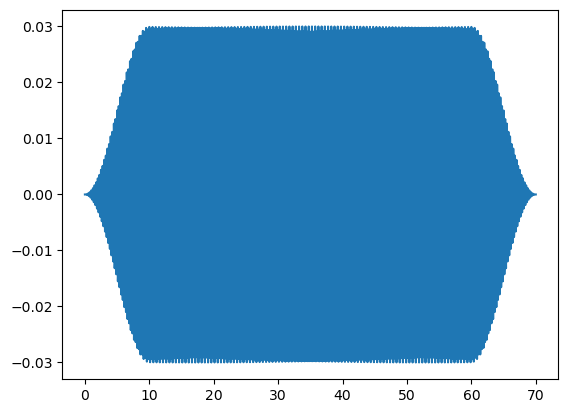

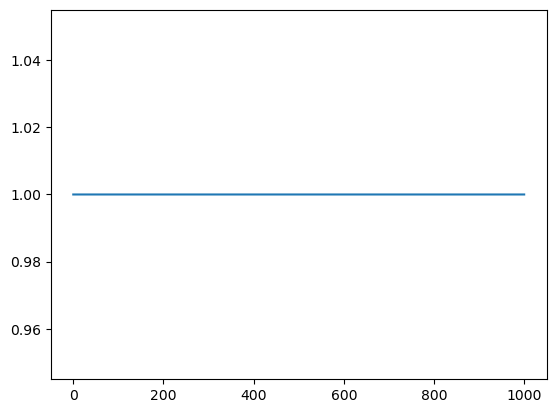

In [147]:
# process
# process_dict['name']=control_list
class process():
    # 0.生成哈密顿量x
    # 1.时间平移,tlist
    # 2.长度统计
    # 3.波形plot
    # 4.组装拆分


    def __init__(self,process_params=[[300,'p','xz','01'],[0,'bias','z','0']]) -> None:
        self.process_params=process_params
        self.wave_dict=Pulse.wave_dict
        self.pulse_dict=Pulse.pulse_dict
        self.pulse_dict.update({'bias':self.wave_dict['bias']([0,20,1,0]),
                         'idle':self.wave_dict['delay']()})
        self.process_dict={'process1':[[0,'bias','x','0'],[0,'bias','z','0']],
                           'idle':[0,'idle','I',0]}

    def _sort_pulse(self):
        pp=self.process_params
        pulse_cannel={}
        t0_list={}
        for p in pp:
            t0,pulse,op,tar=tuple(p[:4])
            if len(p)==5:
                tar_type=p[-1]
            else:
                tar_type='q'*len(op)
            pc=op+tar+'_'+tar_type
            pulse_cannel[pc]=pulse_cannel.get(pc,[])
            pulse_cannel[pc].append(pulse)
            t0_list[pc]=t0_list.get(pc,[])
            t0_list[pc].append(t0)

        for pc in pulse_cannel:
            ps=pulse_cannel[pc]
            ts=t0_list[pc]
            ps=[self.pulse_dict[p] for p in ps]
            for i in range(len(ps)):
                ps[i].t0=ts[i]
            pulse_cannel[pc]=self.wave_dict['sup']([0,ps])
        for p in pulse_cannel.values():
            p.plot
            
            
            
        # pass

    @property
    def plot(self):
        func=self.__call__
        tlist=np.linspace(self._t0,self.tf,int(self.length)*50)
        fix,ax=plt.subplots()
        ax.plot(tlist,list(map(func,tlist,tlist)))

        return fix,ax

    def _generate_control_operator(self,control_params=[0,'pulse0',[1,2],'xx']):
        t0,pulse,tar,control_type=tuple(control_params) 
        if type(pulse)==str:
            pulse=self.pulse_dict[pulse]
        if  pulse.is_constant:
            c=pulse.constant
            Hc=self.upto(tar,control_type)
            return c*Hc
        else:
            pulse.t0=t0
            Hc=self.upto(tar,control_type)
            return [Hc,pulse]

    # @property
    # def _Hcontrol_list(self):
    #     control_list=self.process_params
    #     Hcontrol_list=[self._generate_control_operator(c_params) 
    #                        for c_params in control_list]
    #     return Hcontrol_list


# today todo list
# 1、process写完
# 2、run_lego写完
# 3、一、二维参数扫描写完
# 4、坐标系变换写完
# 5、写个不带collapse的demo
# 6、LO与其他波的区分
# D7、腔相关的代码重写



# 坐标系变换

class Model(qcircuit):
    '''
    init:
        qcircuit:                   *qc - class qcircuit
    method:
        add time-depend control:    *


    drive,
    D1.pulse
    D1.1 shape
    D1.2 params
    D1.3 time_sequence

    2.hamilton
    D2.1 type
    D2.2 target

    3.process
    control_list=[control_params1,control_params2]
    control_params=[t0,pulse,tar,type]


    3.0 opti-params
    3.1 combine
    3.2 visualize
    3.3 fidelity

    run,
    1.lego

    analyze
    1.scan
    2.optimize

    '''
    def __init__(self,qc_params=(), mod_params=dict(
                pulse_dict={'bias':bias_LO_wave()},
                process_dict={'proc1':[[0,'bias','0','z']]}
                # control_list=[[t0,pulse,tar,type],[t1,...]],
                # control_list=[],pulse_dict=pulse_dict,
                ),
                **params) -> None:
        
        super().__init__(qc_params,params=params)
        self.wave_dict=Pulse.wave_dict
        self.pulse_dict={'bias':self.wave_dict['bias']([0,100,1,0]),
                         'delay':self.wave_dict['delay'](),
                         'pulse0':pulse0}
        self.process_dict={'process0':[[0,'bias','0','x'],[0,'delay','0','z']],
                           'process_test':[[0,'pulse0','0','x'],
                                           [0,'pulse0','1','x'],
                                           [0,'pulse0','2','x']],
                           'delay':[[0,'delay',0,'I']]}
        self.pulse_dict.update(mod_params['pulse_dict'])
        self.process_dict.update(mod_params['process_dict'])


        self.mod_params=dict(
            pulse_dict=self.pulse_dict,
            process_dict=self.process_dict
        )
        
        self.H_dict={}

        # self.mod_params.update(mod_params)
        self._set_params_mod(self.mod_params)
        self.simu_params0=copy(self.mod_params)

    def _set_params_mod(self,dic):
        for p in dic:
            setattr(self,p,dic[p])

        self._H_dict
    def update_mod(self,dic=(),**params):
        self.mod_params.update(dic)
        self.mod_params.update(params)
        self.mod_params(self.mod_params)
    
    def _generate_control_operator(self,control_params=[0,'pulse0',[1,2],'xx']):
        t0,pulse,tar,control_type=tuple(control_params) 
        if type(pulse)==str:
            pulse=self.pulse_dict[pulse]
        if  pulse.is_constant:
            c=pulse.constant
            Hc=self.upto(tar,control_type)
            return 2*pi*c*Hc
        else:
            pulse.t0=t0
            Hc=self.upto(tar,control_type)
            return [2*pi*Hc,pulse]
    def _generate_density_matrix(self,state='0'):
        if state=='0':
            return self.proj[0]
        else:
            return self.direct_product_state(state)


    @property
    def _H_dict(self):
        for process_name in self.process_dict:
            control_list=self.process_dict[process_name]
            Hcontrol_list=[self._generate_control_operator(c_params) 
                           for c_params in control_list]
            H=[2*pi*self.H0]
            H.extend(Hcontrol_list)
            self.H_dict[process_name]=H

    
    def GateProcess(self,result,population=True,bloch=True,show_list=[0,1,2,3,-1]):
        if population:
            fig, ax = plt.subplots()
            ax.plot(result.times ,
                    np.transpose(result.expect))
            # np.transpose([result.expect[p]]))
            # np.transpose([expect for expect in result.expect]))
            # np.transpose([result.expect[i] for i in show_list]))
            ax.set_xlabel('t/ns')
            ax.set_ylabel('Population')
            # ax.legend(['P00','P11','P22','tot','error'])
            plt.show()
        if bloch:
            b=Bloch()
            b.add_points([result.expect[0],result.expect[1],
                          result.expect[2]],'l')
            b.show()

    # def 

    def run_lego(self,  
                 run_params=dict(  
                     pre_result=None,   rho0='0',           process='idle',
                     plot=False,        population=True,    bloch=False,)
                     ):
        '''return result'''



        # if plot:print(f'run start,T={L}')
        locals().update(run_params)
        if pre_result==None:
            pass
            # rho0=proj[to(rho0)]
        else:
            self.update(tp=res_pre.times[-1])
            rho0=res_pre.final_state
            
        
        tlist=np.linspace(self.tp,self.tp+L,int(L*50)+1)
        arrow=self.arrow_squ
        op=Options(store_final_state=True)
        H=      self.H_down  if enve_type=='d' \
        else    self.H_up    if enve_type=='u' \
        else    self.H_plant if enve_type=='p' \
        else    self.H
        



        
        # rho_mix=self.state_mix*self.state_mix.dag()
        # e_ops=[proj[to(0)],proj[to(1)],proj[to(2)],rho_mix,rho_mix]
        e_ops=[proj[to(0)],proj[to(1)],proj[to(2)]]
        result=mesolve(H,rho0,tlist,None,e_ops,options=op)
        tot,error=[],[]
        
        tot=[i+j+k for i,j,k in 
             zip(result.expect[0],result.expect[1],result.expect[2])]
        leakage=[1-i for i in tot]
        coeff=np.abs(1-arrow[0])+np.abs(0-arrow[1])+np.abs(0-arrow[2])

        if mix:
            # ==max_delta_ijk
            # error=[np.abs(i-j)+np.abs(j-k)+np.abs(l) for i,j,k,l in 
            #        zip(result.expect[0],result.expect[1],result.expect[2],
            #            leakage)]

            error=[(np.abs(i-arrow[0])+np.abs(j-arrow[1])+np.abs(k-arrow[2])
                    +np.abs(l))/coeff for i,j,k,l in 
                    zip(result.expect[0],result.expect[1],result.expect[2],
                       leakage)]
        else:
            error=[t-p for t,p in zip(tot,result.expect[rho_tar])]
        
        # result.expect[3]=tot
        result.expect.append(tot)
        result.expect.append(leakage)
        result.expect.append(error)
        result.min=min(error)
        #expect[3]=tot,expect[-1]=error
        if res_pre!=None:
            tpm=copy(list(res_pre.times))
            tpm.extend(result. times)
            result.times=tpm
            for i in range(len(result.expect)):
                rpm=copy(list(res_pre.expect[i]))
                rpm.extend(result.expect[i])
                result.expect[i]=rpm

        
        if plot:
            self.GateProcess(result=result,
                             population=population,bloch=bloch)
            print('run end')

        return result


    def run(self,   rho0=None,  process='delay',    e_ops=None,
                    plot=True,  population=True,    pre_result=None):
        
        '''return result or [result,rrsult_norm]'''
        # if plot:print(f'run start,T={self.L}')


        proj=self.proj
        # get rho0
        if pre_result!=None:
            if rho0!=None:
                print('input rho0 will be disused when exist input pre_result')
            rho0=pre_result.final_state
        else:
            if rho0==None:
                rho0='0'
            rho0=self._generate_density_matrix(rho0)



        
        # H=self.H_dict['process']

        # proc=self.process_dict[process]
        # H=self.generate_H(proc)
        # tlist=proc.tlist
        H=self.H_dict[process]
        tlist=np.linspace(0,70,100000)

        op=Options(store_final_state=True)


        if e_ops==None:
            e_ops=[proj[i] for i in range(3**self.qubit_num)]


        result=mesolve(H,rho0,tlist,None,e_ops,options=op)
        
        if plot:
            self.GateProcess(result=result,
                             population=population,bloch=False)
            print('run end')
        return result

    def run_fin(self,tstart=None,tstop=None,tstep=None,
                    plot=False,population=True,bloch=False):
        L,t_edge=self.L,self.t_edge
        rl=self.run_lego
        if tstart==None:
            tstart,tstop=2*t_edge,self.L
        if tstep==None:
            tstep=1*(int(self.L/t_edge))+1
        tplist=np.linspace(tstart,tstop,tstep)

        class output:
            pass
        times,expect=[],[]

        res=rl(enve_type='u',  L=t_edge)
        res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)

        for tp in tplist[1:]:
            tp_pre=res.times[-1]
            L=tp-tp_pre
            res     =rl(res_pre=res,    enve_type='p',  L=L-t_edge)
            res_fin =rl(res_pre=res,    enve_type='d',  L=t_edge)
            times.append(res_fin.times[-1])
            expect.append(np.transpose(res_fin.expect)[-1])
            
        expect=np.transpose(expect)

        output.times=times
        output.expect=expect

        if plot:
            self.GateProcess(result=output,
                             population=population,bloch=bloch)
            print('run end')
        return output

    def run_fin_old(self,tstart,tstop,tstep,
                plot=False,population=True,bloch=True,show=[0,1,2,-1]):
        t_fin_list=np.linspace(tstart,tstop,tstep)
        class output:
            pass
        output.times=t_fin_list
        output.expect=[]
        for t in t_fin_list:
            self.update(L=t)
            res=copy(self.run())
            output.expect.append(np.transpose(res.expect)[-1])
        output.expect=np.transpose(output.expect)
        if plot:
            self.GateProcess(result=output,
                             population=population,bloch=bloch)
            print('run end')
        return output
    


# qc=Model(qc_params=dict(
#     # couple_list=[[0.5,[0,1],'xx']],
#     qubit_num=3,dim_num=4,
#     w_q_list=[5,5.2,5.4],
#     yita_list=[0.1,0.15,0.2]
#     # qubit_num=1,dim_num=6,
#     # w_q_list=[5],yita_list=[0.1]
#     ))
# qc.add_coupling([0.1,[0,2],'xx'])
# qc.add_coupling([0.03,[0,1],'xx'])
# qc.energies_plot
# s=simulation(qc,)
# s.H0
p=process()
p._sort_pulse()

In [ ]:
qc.eigenstates_plot([0,1])
qc.direct_product_to_eigen_plot('100')

In [ ]:
qc.ee

In [ ]:
qc.run(process='process_test')
# qc.H_dict
# qc._generate_density_matrix('0')

In [ ]:
# For example

# 1. qc.params  
qc_params=dict(
    couple_list=[[0.1,'01','xx'],[0.13,[1,2],'xx']],
    qubit_num=3,dim_num=4,
    w_q_list=[5,5.2,5.4],
    yita_list=[0.1,0.15,0.2]#
    # resonator_num=2,dim_num=6,
    # w_r_list=[7,8]
    )
# qc=qcircuit(qc_params=qc_params)
# qc.add_coupling([0.01,[0,2],'xx'])
# qc.direct_product_to_eigen_plot('001')
# qc.eigenstates_plot([1,3,5])
# qc.direct_product_state('010')

# 2. Model.params
# mod_params=dict(
#     pulse_dict=pulse_dict,
#     process_dict=process_dict
#     )
my_model=Model(
    qc_params=qc_params,
    mod_params=mod_params
    )


def f(t,p,t0):
    p_enve_name=[cos_upedge_wave,plat_wave,cos_downedge_wave]#,cos_LO_wave]
    p_enve_para=[[6,    t,1,0],
                 [3,    p,1,0],
                 [3,    t,1,0],]
    p_enve=[0,p_enve_name,p_enve_para]
    p_LO=[t0,1000,1,0,0.3,0]
    p_tot_name=[connect_wave,cos_LO_wave]
    p_tot_para=[p_enve,p_LO]
    return [5,p_tot_name,p_tot_para]
pulse0=mix_wave(f(10,20,0))
pulse1=mix_wave(f(10,20,pi))


In [ ]:
# qc.eigenstates_plot(range(3))
# np.transpose(qc.es)
qc.direct_product_to_eigen_plot('000')
# np.transpose(list(qc.es))
# np.transpose(qc.es[0])
# list(qc.es[0])
# list(np.transpose(qc.es[0])[0])
# np.matrix(sigmax())

In [ ]:
qc=simulation(qc_params=dict(qubit_num=3,dim_num=4,w_q_list=[5,5.3,5.4],yita_list=[0.1,0.15,0.2]))
# qc.add_coupling([1,[0,2],'xx'])
# qc.energies_plot
# s=simulation(qc,)
# s.H0
qc
# qc.energies_plot

In [ ]:
plot_wigner_fock_distribution(qc.eig[1][10])

In [ ]:
tuple([1,2,3,[1,4]])

In [ ]:
#单继承， 子类对父类扩展：新增方法、重写方法、子类中使用super().调用父类方法
class Animal():
    def eat(self):
        print("吃")
 
    def run(self):
        print("跑")
 
    def drink(self):
        print("喝")
 
    def sleep(self):
        print("睡")
 
 
class Dog(Animal):

    def bark(self):
        print("汪汪叫")
    a=1
 
d=Dog
d.b=2

class XiaoTianQuan(d):
 
    def fly(self):
        print("会飞")
 
    def bark(self):
        # 1. 针对子类特有的需求，编写代码
        print("天籁之音")
 
        # 2. 使用super(). 调用原本在父类中封装的方法
        # super().bark()
 
        # # 3. 增加其他子类的代码
        # print("OKOK")
 
 
# 创建一个哮天犬对象
xtq = XiaoTianQuan()
 
xtq.b